# Churn Analysis of Telco Customer database

### 1) Problem Statement


The main objectives of this work is to identify the factors influencing churn and create a model to predict churn.

### 2) Model fitting for Churn prediction

#### 2.1) Import relevant packages

In [27]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
import xgboost
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer, recall_score

from sklearn.tree import DecisionTreeClassifier,export_graphviz

import shap
import joblib

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

#### 2.2) Corrected dataset

In [5]:
data_df = pd.read_csv("D:\Repositories\ml-churn/artifacts\data_ingestion\main_data.csv")

#### 2.3) Verify the schema

In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


#### 2.4) Apply <i>get_dummies</i> to OneHotEncode variables with multiple options

In [7]:
names = list(data_df.columns[[6,7,8,9,10,11,12,13,14,15,16,17]])

dd = data_df

for name in names: 
    dd = pd.get_dummies(dd, columns=[name], dtype=int)

#### 2.5) Drop duplicated columns related to "no internet service"

In [8]:
dd.drop(columns="customerID", inplace=True)
# dd.drop(columns= "InternetService_No", inplace= True)
dd.drop(columns= "OnlineSecurity_No internet service", inplace= True)
dd.drop(columns= "OnlineBackup_No internet service", inplace= True)
dd.drop(columns= "DeviceProtection_No internet service", inplace= True)
dd.drop(columns= "TechSupport_No internet service", inplace= True)
dd.drop(columns= "StreamingTV_No internet service", inplace= True)
dd.drop(columns= "StreamingMovies_No internet service", inplace= True)

#### 2.6) Apply data transformation

In [9]:
Ord_encoder = LabelEncoder()
Std_encoder = StandardScaler()
One_henconder= OneHotEncoder()

Ordinal_variables = ["gender", "SeniorCitizen","Partner","Dependents","Churn"]
Numeric_variables = ["tenure","MonthlyCharges","TotalCharges"]
One_hot_variables = ["InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]

def label_encoder_transformer(variables):
    encoded_variable = variables.apply(lambda col: Ord_encoder.fit_transform(col))
    return encoded_variable


# preprocessor = ColumnTransformer(transformers=[
#                                 ("Ordinal", FunctionTransformer(label_encoder_transformer, validate=False), Ordinal_variables),
#                                 ("Standar", Std_encoder, Numeric_variables),
#                                 ("Onehot", One_henconder, One_hot_variables)
#                                 ])
# dd = preprocessor.fit_transform(dd)

dd[Ordinal_variables] = dd[Ordinal_variables].apply(lambda col: Ord_encoder.fit_transform(col))
dd[Numeric_variables] = Std_encoder.fit_transform(dd[Numeric_variables])

### 3) Data split and hyperparameter optimization for XGBoost Classification algorithm

In [16]:
X_train, X_test, y_train, y_test = train_test_split(dd.drop(columns="Churn"), dd["Churn"], test_size=0.3, random_state=42, stratify=dd["Churn"])


param_grid = {
    'n_estimators': [400],
    'eta': [0.005],
    'max_depth' : [4],
    'alpha':[0.03],
    'lambda': [0.03],
    'eval_metric':["aucpr"],
    'subsample':[0.5],
    'colsample_bytree':[0.5],
    'gamma':[5],
    'learning_rate':[0.05],
    'scale_pos_weight':[1.5]
}



# Create a Gaussian Mixture model
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring= "roc_auc", n_jobs=-1)

#### 3.1) Verify if train and test data is stratified

In [17]:
(y_test == 1).sum()/y_test.count()

0.26587677725118486

In [18]:
(y_train == 1).sum()/y_train.count()

0.2657456318569687

#### 3.2) Fit the grid

In [19]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'alpha': [0.03], 'colsample_bytree': [0.5],
                         'eta': [0.005], 'eval_metric': ['aucpr'], 'gamma': [5],
                         'lambda': [0.03], 'learning_rate': [0.05],
                         'max_depth': [4], 'n_estimators': [400],
                         'scale_pos_weight': [1.5], 'subsample': [0.5]},
             scoring='roc_auc')

#### 3.3) Inspect the results obtained from grid

In [20]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_colsample_bytree,param_eta,param_eval_metric,param_gamma,param_lambda,...,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.449399,0.023429,0.009802,0.001725,0.03,0.5,0.005,aucpr,5,0.03,...,0.5,"{'alpha': 0.03, 'colsample_bytree': 0.5, 'eta'...",0.836686,0.853051,0.878169,0.848357,0.838267,0.850906,0.014942,1


#### 3.4) Get parameters from best model

In [ ]:
grid_search.best_estimator_.get_params


#### 3.5) Visualize the AUC curve and select a <b>THRESHOLD</b>

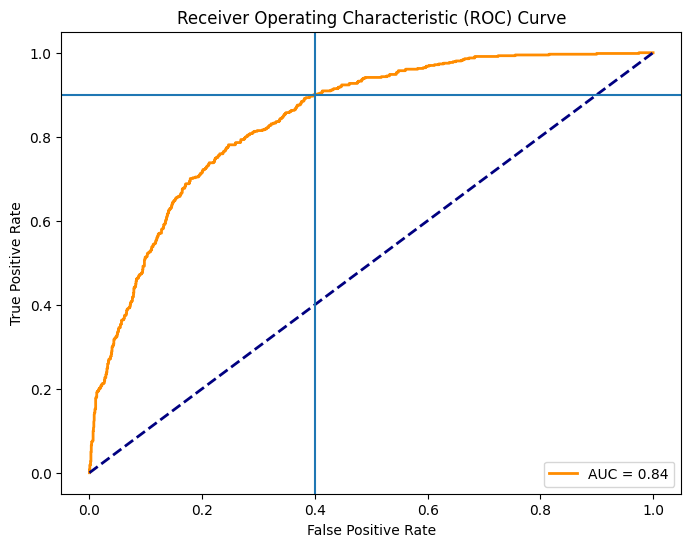

In [92]:
best_model = grid_search.best_estimator_
THRESHOLD = 0.4

# Predict probabilities on the test set
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = auc(fpr, tpr)
app_prob = tpr[np.where(np.isclose(THRESHOLD, fpr,rtol=1e-2))]
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.axhline(np.mean(app_prob))
plt.axvline(THRESHOLD)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### 3.6) Calculation of confusion matrix for the proposed THRESHOLD value and compare with the one obtained from the model fit

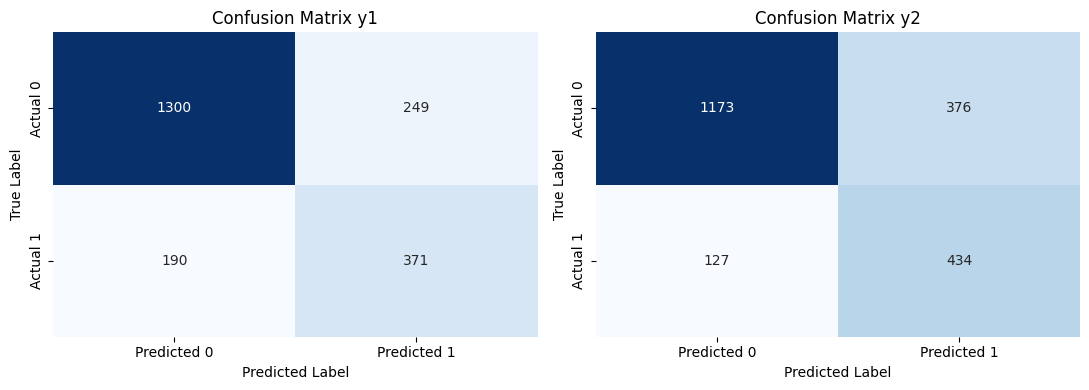

In [93]:
y_pred  = grid_search.best_estimator_.predict(X_test)
y_pred1 = np.where(grid_search.best_estimator_.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

# Create a confusion matrix
y_preds = {"y1" : y_pred , "y2": y_pred1}


fig, ax = plt.subplots(1,2, figsize=(11,4))
axes = ax.ravel()

for axes,y_values in zip(axes , y_preds):

    conf_matrix = confusion_matrix(y_test, y_preds[y_values])
    # Plot the confusion matrix using seaborn
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax = axes)
    axes.set_xlabel('Predicted Label')
    axes.set_ylabel('True Label')
    axes.set_title(f'Confusion Matrix {y_values}')

plt.tight_layout()

Changing the THRESHOLD value will cause a tradeoff between precision and recall, the client must decide

#### 3.7) Define a metrics function, to determine performance metrics

In [10]:

def calculate_metrics(conf_matrix):
    """
    Calculate various performance metrics from a confusion matrix.

    Parameters:
    - conf_matrix: 2x2 NumPy array, confusion matrix with rows representing actual classes
                  and columns representing predicted classes.

    Returns:
    - metrics_dict: Dictionary containing calculated performance metrics.
    """
    TP = conf_matrix[1, 1]  # True Positives
    TN = conf_matrix[0, 0]  # True Negatives
    FP = conf_matrix[0, 1]  # False Positives
    FN = conf_matrix[1, 0]  # False Negatives

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)
    fpr = FP / (FP + TN)
    fdr = FP / (TP + FP)
    fnr = FN / (TP + FN)
    mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    # Create a dictionary to store the metrics
    metrics_dict = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1 Score': f1_score,
        'False Positive Rate (FPR)': fpr,
        'False Discovery Rate (FDR)': fdr,
        'False Negative Rate (FNR)': fnr,
        'Matthews Correlation Coefficient (MCC)': mcc,
    }

    return metrics_dict


#### 3.8) Calculate performance matrix for both THRESHOLD values

In [95]:
THRESHOLD = 0.4
y_pred1 = np.where(grid_search.best_estimator_.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
y_pred2 = grid_search.best_estimator_.predict(X_test)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred1)
conf_matrix2 = confusion_matrix(y_test, y_pred2)

print(calculate_metrics(conf_matrix))
print(calculate_metrics(conf_matrix2))

{'Accuracy': 0.761611374407583, 'Precision': 0.5358024691358024, 'Recall': 0.7736185383244206, 'Specificity': 0.7572627501613944, 'F1 Score': 0.6331145149525893, 'False Positive Rate (FPR)': 0.24273724983860556, 'False Discovery Rate (FDR)': 0.4641975308641975, 'False Negative Rate (FNR)': 0.22638146167557932, 'Matthews Correlation Coefficient (MCC)': 0.48227013903605}
{'Accuracy': 0.7919431279620853, 'Precision': 0.5983870967741935, 'Recall': 0.661319073083779, 'Specificity': 0.8392511297611362, 'F1 Score': 0.6282811176968671, 'False Positive Rate (FPR)': 0.16074887023886378, 'False Discovery Rate (FDR)': 0.40161290322580645, 'False Negative Rate (FNR)': 0.33868092691622104, 'Matthews Correlation Coefficient (MCC)': 0.4854932035779744}


### 4) Visualization of model important variables using <b>SHAP</b> package

#### 4.1) Calculate the shap values using best model

In [97]:
X100 = shap.utils.sample(dd.drop(columns="Churn"), 100)
explainer = shap.Explainer(grid_search.best_estimator_.predict, X100)
shap_values = explainer(dd.drop(columns="Churn"))

PermutationExplainer explainer: 7033it [09:50, 11.76it/s]                          


#### 4.2) Waterfall plot to observe the important variables for isolated values of <b>X</b>

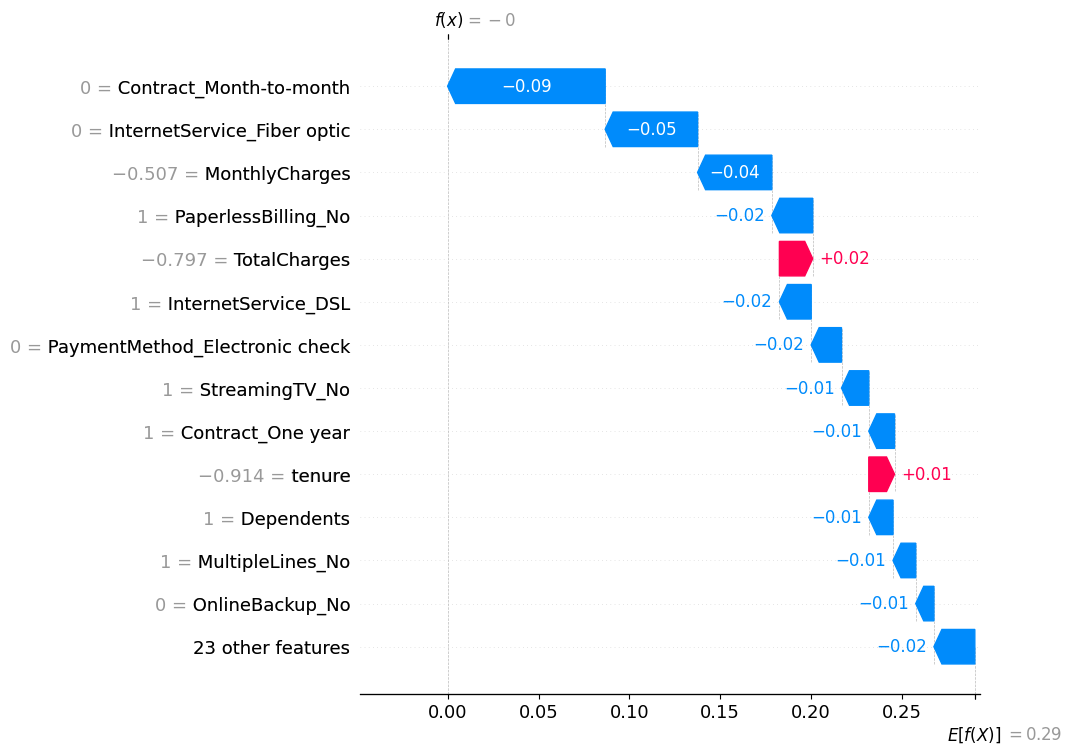

In [98]:
shap.plots.waterfall(shap_values[40], max_display=14)

#### 4.3) For a more global response analysis use beeswarm plot

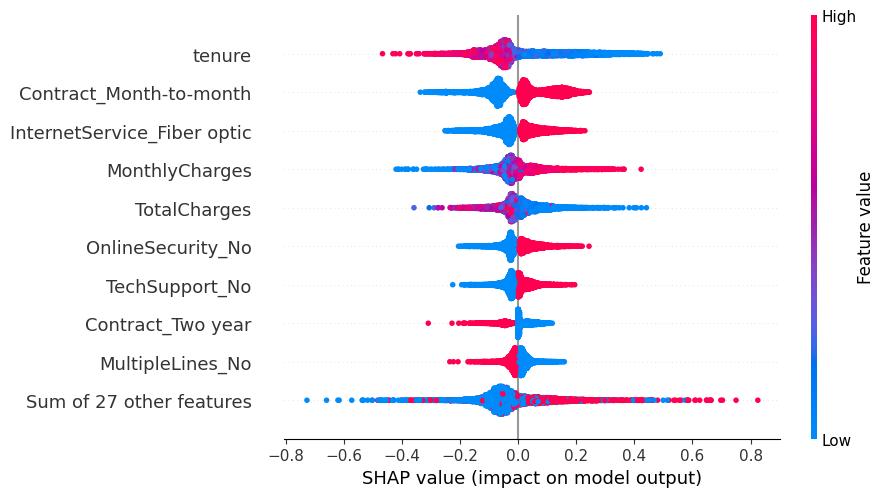

In [99]:
shap.plots.beeswarm(shap_values)

From the plot it can be observer that:
<ul>
  <li>tenure variable have a noticeable impact in the response, clients that show high tenure have a low probability of Churn</li>
  <li>M-M contract have the commented effect, people with M-M contract tends to Churn, people that have a +2 years contract tends to Churn less</li>
  <li>Internet-Fiber have a high impact in predict Churn rate, another clue of clients leaving this service.</li>
  <li>People with high Monthly Charges have higher Churn rate -> could be changing services or just jumping for bundles.</li>
  <li>People with low total Charge tends to Churn more -> can represent the amount of hire services</li>
  <li>Online aditional services as Online security and Tech support shows that people that hire this services have a lower Churn rate</li>
  <li>People who doesn't have Mutiple lines phone services have a lower Churn rate</li>
</ul>

From the wide of the shap values distribution, it can be observer that the contract type, monthly charges, and online services have a high impact in Churn rates. Fiber optic service have to be reviewed, to investigate if its an internal problem or people is leaving for different companies.

#### 4.3) The total effect is presented in the <b>summary_plot</b> of shap values

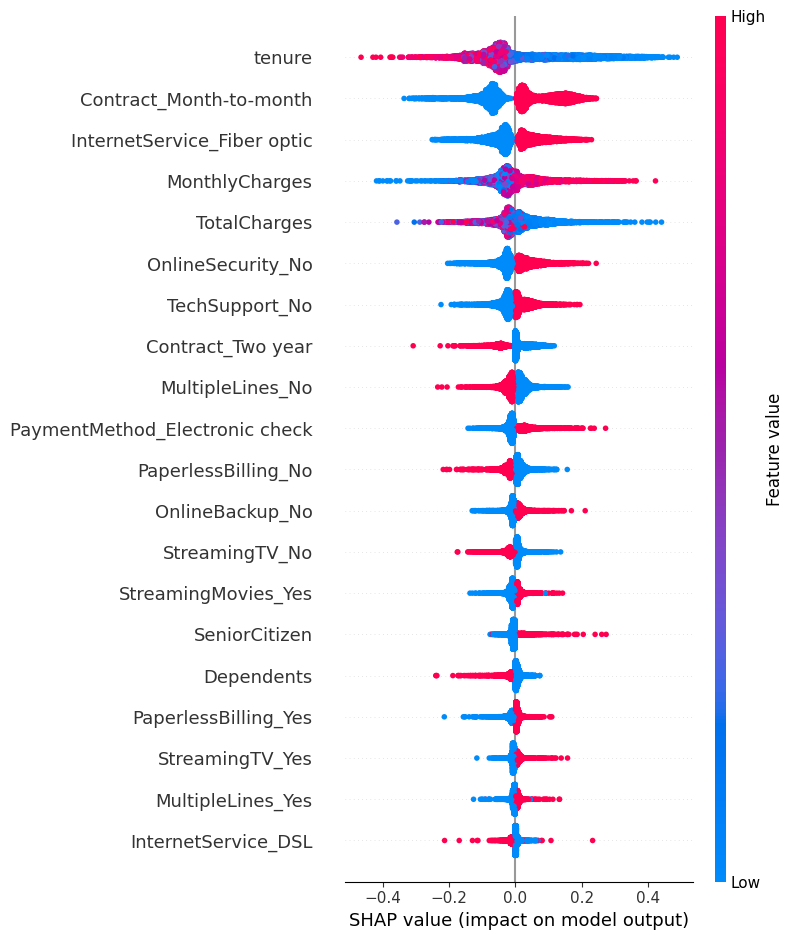

In [100]:
shap.summary_plot(shap_values)

For more interpretations, take in account that, variables that move wide to the right have a high impact in Churn rates, 
variables that move to the left side lower the Churn rates.

### 5) For comparison a Neural network for classification model is trained using <b>Pytorch</b>

#### 5.1) Import packages

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

#### 5.2) Transform dataframes to tensors

In [63]:
X_train_tensor = torch.FloatTensor(X_train.to_numpy(dtype='float32'))
y_train_tensor = torch.FloatTensor(y_train.to_numpy(dtype='float32').reshape(-1, 1))
X_test_tensor = torch.FloatTensor(X_test.to_numpy(dtype='float32'))
y_test_tensor = torch.FloatTensor(y_test.to_numpy(dtype='float32').reshape(-1, 1))


#### 5.3) Create ANN structures

In [64]:
class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(CustomNN, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define the Skorch wrapper for the neural network
class CustomNetClassifier(NeuralNetClassifier):
    def __init__(self, module, **kwargs):
        super(CustomNetClassifier, self).__init__(module, **kwargs)

# Create a Skorch classifier
classifier = CustomNetClassifier(
    module=CustomNN,
    module__input_size=X_train.shape[1],
    module__hidden_sizes=[16, 8],  # Specify the hidden layer sizes as needed
    module__output_size=1,
    max_epochs=50,  # Adjust the maximum number of epochs as needed
    lr=0.001,
    optimizer=optim.Adam,
    criterion=nn.BCELoss,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=10)],
)


#### 5.4) Fit the model with gridsearchCV 

In [69]:
X_train_tensor = X_train_tensor.float()
y_train_tensor = y_train_tensor.float()

# Training the model
classifier.fit(X_train_tensor, y_train_tensor)

# Evaluate the model on the test set
accuracy = classifier.score(X_test_tensor, y_test_tensor)
print(f'Test Accuracy: {accuracy:.4f}')

# Example usage with GridSearchCV
params = {
    'lr': [0.1],
    'module__hidden_sizes': [[64,16]],
}

grid = GridSearchCV(classifier, params, cv=3, scoring='accuracy', verbose=1)
grid.fit(X_train_tensor, y_train_tensor)
print(f'Best parameters: {grid.best_params_}')
print(f'Best accuracy: {grid.best_score_}')

Re-initializing module because the following parameters were re-set: hidden_sizes, input_size, output_size.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7632       0.2660        0.7456  0.1600
      2        0.7190       0.6132        0.6847  0.1330
      3        0.6449       0.7340        0.6057  0.1300
      4        0.5739       0.7340        0.5416  0.1210
      5        0.5091       0.7431        0.4840  0.1260
      6        0.4596       0.7797        0.4516  0.1300
      7        0.4347       0.7898        0.4390  0.1270
      8        0.4247       0.7868        0.4352  0.1280
      9        0.4213       0.7888        0.4337  0.1370
     10        0.4193       0.7878        0.4321  0.1260
     11        0.4181       0.7868        0.4315  0.1340
     12        0.4170       0.7878        0.4301  0.1360
     13        0.4153       0.7868      

In [66]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(calculate_metrics(conf_matrix))


{'Accuracy': 0.7881516587677725, 'Precision': 0.6239130434782608, 'Recall': 0.5115864527629234, 'Specificity': 0.8883150419625565, 'F1 Score': 0.5621939275220372, 'False Positive Rate (FPR)': 0.11168495803744351, 'False Discovery Rate (FDR)': 0.3760869565217391, 'False Negative Rate (FNR)': 0.48841354723707664, 'Matthews Correlation Coefficient (MCC)': 0.42789703678224317}


#### 5.5) Plot AUC-ROC curve

Mean of empty slice.
invalid value encountered in scalar divide


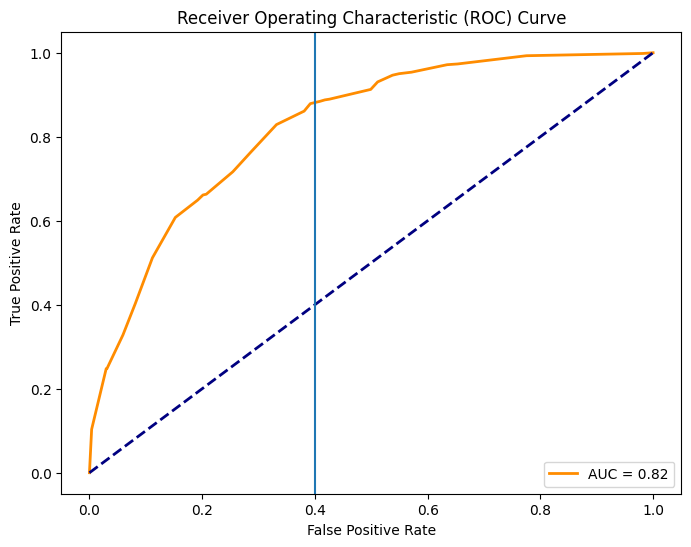

In [67]:
best_model = grid_search.best_estimator_
THRESHOLD = 0.4

# Predict probabilities on the test set
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = auc(fpr, tpr)
app_prob = tpr[np.where(np.isclose(THRESHOLD, fpr,rtol=1e-2))]
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.axhline(np.mean(app_prob))
plt.axvline(THRESHOLD)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 6) Make a decision tree to fit data, and fit a visualization about how clients works

#### 6.1) Import packages and fit the grid

In [11]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier()

# Define parameter grid
param_grid = {
    'criterion': ['gini'],  # Split criterion
    'max_depth': [5],  # Maximum depth of the tree
    'min_samples_split': [2],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [4],  # Minimum number of samples required to be at a leaf node
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    model,
    param_grid,
    scoring= "roc_auc",  # Replace 'custom_scorer' with the metric you want to use
    cv=5,  # Adjust the number of folds for cross-validation
    n_jobs=-1,  # Use parallel processing if possible
)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the performance
# You can use your custom scoring metric or other metrics like accuracy, precision, recall, etc.
# For example: print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [73]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(calculate_metrics(conf_matrix))


{'Accuracy': 0.7881516587677725, 'Precision': 0.6239130434782608, 'Recall': 0.5115864527629234, 'Specificity': 0.8883150419625565, 'F1 Score': 0.5621939275220372, 'False Positive Rate (FPR)': 0.11168495803744351, 'False Discovery Rate (FDR)': 0.3760869565217391, 'False Negative Rate (FNR)': 0.48841354723707664, 'Matthews Correlation Coefficient (MCC)': 0.42789703678224317}


#### 6.2) Plot AUC-ROC curve

Mean of empty slice.
invalid value encountered in scalar divide


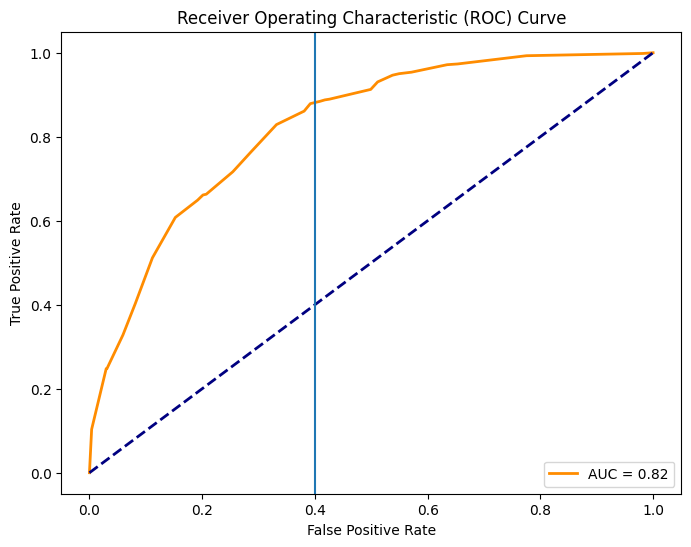

In [12]:
best_model = grid_search.best_estimator_
THRESHOLD = 0.4

# Predict probabilities on the test set
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = auc(fpr, tpr)
app_prob = tpr[np.where(np.isclose(THRESHOLD, fpr,rtol=1e-2))]
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.axhline(np.mean(app_prob))
plt.axvline(THRESHOLD)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### 6.3) Export decision tree diagram for a better understanding of data

In [13]:
import graphviz

model = DecisionTreeClassifier(criterion= "gini", max_depth= 5, min_samples_split= 2, min_samples_leaf=4)
model.fit(X_train,y_train)
X = dd.drop(columns="Churn")
y = dd["Churn"]

dot_data = export_graphviz(
    model,
    out_file=None,
    feature_names=list(X.columns),
    class_names=[f'Class {i}' for i in set(y)],
    filled=True,
    rounded=True,
)

# Visualize the decision tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render('decision_tree', format='png', cleanup=True)  # Save as PNG or other formats
graph.view('decision_tree')  # Open the visualization in the default viewer

'decision_tree.pdf'